# Wonderful Wines of the World

## Initial Setup

In [34]:
## import libraries

import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns

import os
from math import ceil



In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm


In [3]:
from sklearn.base import clone

from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA, FactorAnalysis

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.preprocessing import OrdinalEncoder

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth


from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE

from sklearn.metrics import silhouette_score, silhouette_samples

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split

from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

import graphviz


In [4]:
import warnings
warnings.filterwarnings('ignore')

# https://stackoverflow.com/questions/56618739/matplotlib-throws-warning-message-because-of-findfont-python
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

# importing sompy enables more logging
logging.disable(logging.INFO)

In [5]:
## Note versions used

print('Pandas version ',pd.__version__)
print('Numpy version ',np.__version__)
print('Scipy version ',sp.__version__)
print('Seaborn version ',sns.__version__)


Pandas version  1.3.3
Numpy version  1.20.3
Scipy version  1.7.0
Seaborn version  0.11.2


## Define some constant variables

In [6]:
COLORS=['#d1d646', '#a7ca58', '#78bd6c', '#44af82', '#009c9f', '#4d8b8f', '#516c85', '#544b7b', '#59236f']

CONTRAST_COLORS = [COLORS[i] for i in range(len(COLORS)) if (i%2) == 0]

DIV_COLORS = ['#9faf1f', '#aac55d', '#b5da99', '#d7ebcb', '#fafafa', '#dbc5d5', '#cb9ebf', '#bb77a8', '#ae4c8c']

DEFAULT_PALETTE = sns.color_palette(COLORS)
CONTRAST_PALETTE = sns.color_palette(CONTRAST_COLORS)
DIVERGENT_PALETTE = sns.color_palette(DIV_COLORS)

sns.set_palette(DEFAULT_PALETTE)
DIV_CMAP = LinearSegmentedColormap.from_list("div_colors", DIV_COLORS)


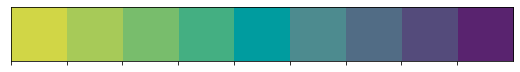

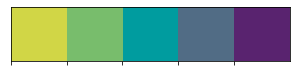

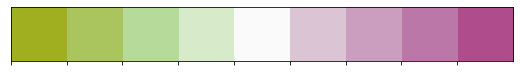

In [7]:
sns.palplot(DEFAULT_PALETTE)
sns.palplot(CONTRAST_PALETTE)
sns.palplot(DIVERGENT_PALETTE)
plt.show()

In [8]:
sns.set_context("paper")
sns.set(style="white")

plt.rcParams['figure.dpi'] = 70

## Define some functions

In [36]:
## Function to plot histograms of numeric features for specified dataframe
def plotHistograms(df, features, rows=4, title = "Numeric Variables' Histograms"):
    fig, axes = plt.subplots(rows, ceil(len(features) / rows), \
                             figsize=(11, 3*rows), \
                             constrained_layout=True)
        
    for ax, feat in zip(axes.flatten(), features):
        ax.hist(df[feat], color=COLORS[0])
        ax.set_title(feat, y=1)
    
    if (len(axes.flatten())) > len(features):
        for f in range(len(axes.flatten())-len(features)):
            axes.flatten()[(f+1)*-1].axis('off')
    plt.suptitle(title)
    save_fig(title, fig)

    plt.show()

In [41]:
## Function to plot histograms of numeric features for specified dataframe
def plot_histograms_boxplots(df, features, rows=4, title = "Histograms of Numeric Variables"):
    if True:
        fig = plt.figure(figsize=(2*rows, 2.8*rows), \
                         constrained_layout=True)
        
        subfigs = fig.subfigures(rows, ceil(len(features) / rows))
    
        for subf, feat in zip(subfigs.flatten(), features):
            axs = subf.subplots(2, 1, sharex=True, \
                                gridspec_kw={'height_ratios': [4,1]})
        
            #df.pivot(columns='Buy')[feat].plot(kind = 'hist', stacked=True, ax=axs[0], color=COLORS[0:2])
            axs[0].hist(df[feat], color=COLORS[0])
            axs[0].set_ylabel(None)
            axs[0].set_title(feat, y=1, fontsize=3*rows)
        
            #sns.boxplot(x=df.loc[df['Buy']==0,feat], ax=axs[1], color=COLORS[0], fliersize=2)
            axs[1].set_xlabel(None)
            sns.boxplot(x=df[feat], ax=axs[1], color=COLORS[0])
            axs[1].set_xlabel(None)

            subf.suptitle(None)
        
        plt.suptitle(title, fontsize=4*rows)
        #if save_plots:
        #    img_counter = save_fig(title, fig)
        
        plt.show()
    else:
        print("show_plots is currently set to False")

In [38]:
# Function that plots boxplot and histogram next to each other
def showBoxHist(df, col, logBool=False):
    if True:
        fig, (ax_hist, ax_box) = plt.subplots(2,
                                    gridspec_kw={"height_ratios": (.85, .15)},
                                    figsize=(9,4)
                                         )
        title='Variable Distribution: ' + col
        sns.boxplot(x=df[col], ax=ax_box, color=COLORS[0])
        ax_box.set(yticks=[], xlabel=None)
        ax_box.axis('off')

        ax_hist.hist(df[col], color=COLORS[0])
        #sns.histplot(x=df[col], ax=ax_hist, color=COLORS[0])
        ax_hist.set(title=title, xlabel=None)
    
        sns.despine(ax=ax_box, left=True)    
        sns.despine(ax=ax_hist)

        plt.show()
    else:
        print("show_plots is currently set to False")

In [27]:
def getIQR(df, colname) :
    q25 = df[colname].quantile(.25)
    q75 = df[colname].quantile(.75)
    iqr = (q75 - q25)

    upper_lim = q75 + 2 * iqr
    lower_lim = q25 - 2 * iqr

    above_ul = df.loc[df[colname]>upper_lim]
    below_ll = df.loc[df[colname]<lower_lim]
    
    if len(above_ul) > 0 :
        print(str(len(above_ul)) + " or " + str(round((100*len(above_ul)/len(df)),4)) + "% of rows are above the UL.")
    if len(below_ll) > 0 :
        print(str(len(below_ll)) + " or " + str(round((100*len(below_ll)/len(df)),4)) + "% of rows are below the LL.")

    
    return upper_lim, lower_lim, len(above_ul), len(below_ll)




## Load Dataset

In [87]:
df = pd.read_excel('../data/WonderfulWinesoftheWorld.xlsx')
df_original = df.copy(deep=True)

#df.set_index('Custid', inplace=True)
## Ignore custid because issues
## Hunt down empty custid

df.head(3)

,Custid,Dayswus,Age,Edu,Income,Freq,Recency,Monetary,LTV,Perdeal,Dryred,Sweetred,Drywh,Sweetwh,Dessert,Exotic,WebPurchase,WebVisit
0,5325.0,653.0,55.0,20.0,78473.0,20.0,18.0,826.0,445.0,7.0,67.0,4.0,26.0,2.0,1.0,1.0,36.0,5.0
1,3956.0,1041.0,75.0,18.0,105087.0,36.0,33.0,1852.0,539.0,2.0,49.0,0.0,46.0,1.0,3.0,0.0,20.0,4.0
2,3681.0,666.0,18.0,12.0,27984.0,4.0,56.0,39.0,-7.0,88.0,4.0,29.0,14.0,32.0,21.0,48.0,60.0,8.0


In [90]:
df.isna().sum()
#df[df['Custid']==np.nan]

Custid         1
Dayswus        0
Age            0
Edu            0
Income         0
Freq           0
Recency        0
Monetary       0
LTV            0
Perdeal        0
Dryred         0
Sweetred       0
Drywh          0
Sweetwh        0
Dessert        0
Exotic         0
WebPurchase    0
WebVisit       0
dtype: int64

In [83]:
wine_features = ['Dryred', 'Sweetred', 'Drywh', 'Sweetwh', 'Dessert', 'Exotic']
#value_ = []

## Remove Perdeal because highly correlated with multiple feats


## Remove Monetary because highly correlated with Freq, LTV
value_features = ['Dayswus', 'Recency', 'Freq', 'LTV']


## Remove Frequency and LTV because highly correlated with Monetary
value_features2 = ['Dayswus', 'Recency', 'Monetary']


## Separate Demographic features for cluster descriptions later
demog_features = ['Age', 'Edu', 'Income']


## Try rfm
## 25 meh
## 36 too much

In [45]:
## Check for duplicates

print(df[df.duplicated(keep=False)])

Empty DataFrame
Columns: [Custid, Dayswus, Age, Edu, Income, Freq, Recency, Monetary, LTV, Perdeal, Dryred, Sweetred, Drywh, Sweetwh, Dessert, Exotic, WebPurchase, WebVisit]
Index: []


In [28]:
for v in df.columns.tolist():
    getIQR(df, v)

363 or 3.6296% of rows are above the UL.
117 or 1.1699% of rows are above the UL.
358 or 3.5796% of rows are above the UL.
2 or 0.02% of rows are above the UL.
365 or 3.6496% of rows are above the UL.
474 or 4.7395% of rows are above the UL.
331 or 3.3097% of rows are above the UL.


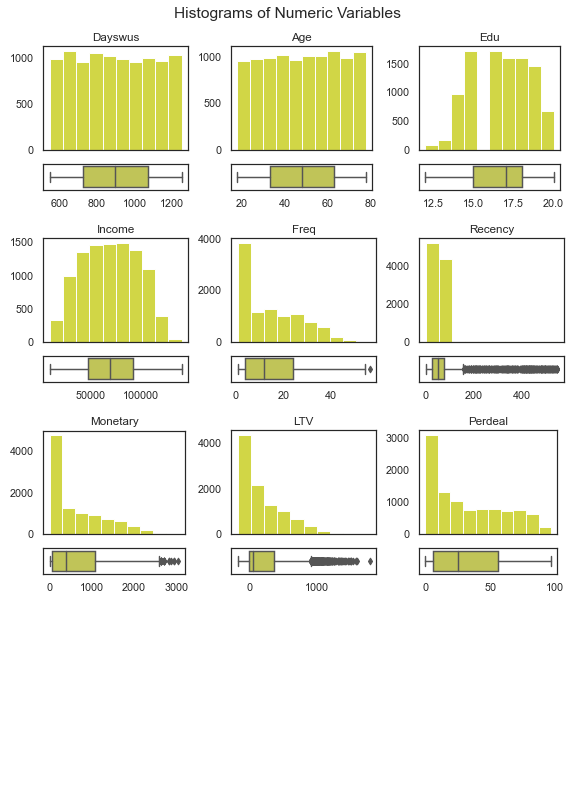

In [47]:
#def plot_histograms_boxplots(df, features, rows=4, title = "Histograms of Numeric Variables"):

plot_histograms_boxplots(df, value_features)

## Remove the two outliers from Dessert
## Remove the one outliers from Sweetred
## No Outliers removed for value features

## Use DBSCAN compare how many it removes
## Consider other outlier detection methods



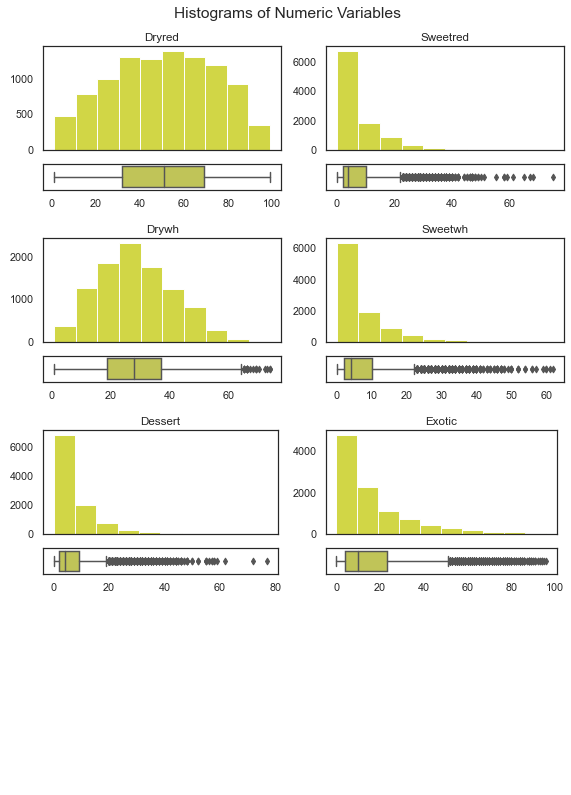

In [91]:
plot_histograms_boxplots(df, wine_features)


In [57]:
def make_corr_heatmap(df, method, title="Triangle Correlation Heatmap"):
    fig = plt.figure(figsize=(21, 11))
    mask = np.triu(np.ones_like(df.corr(method=method), dtype=bool))
    heatmap = sns.heatmap(df.corr(method=method), mask=mask, vmin=-1, vmax=1, annot=True, fmt='.2f' )# ,cmap=DIV_CMAP)
    heatmap.set_title(title, fontdict={'fontsize':18}, pad=6);
    #save_fig(title, fig)
    plt.show()

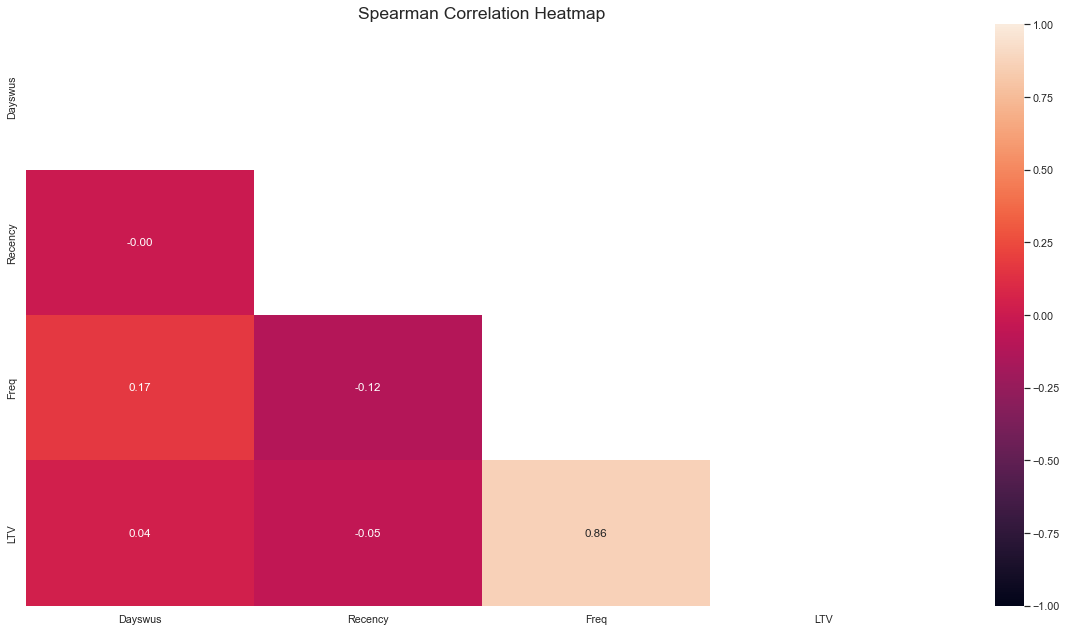

In [81]:
make_corr_heatmap(df[value_features], 'spearman', title="Spearman Correlation Heatmap")

In [ ]:
## Decide on Scaler + Normalizing 
## Ask 
## If we have time, do two batches 



In [ ]:
## Clustering
## Test Normalize + DBSCAN

In [ ]:
## Kmeans
## Hierarchical
## 

In [ ]:
## TSNE, UMAP, dendrogram,bar plots
## 